In [51]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.pipeline import Pipeline
import re
import string
import pickle
import warnings
import os

In [53]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/projek/dataset/RedditToxiScan/clean_20250621_222316.csv'

df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
print(df.head())

print(df['toxic'].value_counts())
print(df['toxic'].value_counts(normalize=True) * 100)

                                            comments  toxic
0                       klo fadli zon goblok boleeeh      1
1  jangan nyinyirin pak fadli zon dia gitu2 punya...      1
2  kritik siapa bisa di penjara fadli zon kritik ...      1
3  hati penuh dendam pikiran selalu negatif mata ...      1
4  kerja anda apa zon bisanya cuma nyinyi r aja s...      1
toxic
1    1173
0     895
Name: count, dtype: int64
toxic
1    56.72147
0    43.27853
Name: proportion, dtype: float64


In [56]:
X = df['comments']
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95, strip_accents='unicode')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape (training): {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape (testing): {X_test_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

print("\nSample feature names:")
print(tfidf_vectorizer.get_feature_names_out()[:20])

Training set size: 1654
Testing set size: 414
TF-IDF matrix shape (training): (1654, 5000)
TF-IDF matrix shape (testing): (414, 5000)
Number of features: 5000

Sample feature names:
['aamiin' 'abang' 'abg' 'abg mandi' 'abis' 'acara' 'aceh' 'acting' 'ada'
 'ada aja' 'ada ajaran' 'ada anjing' 'ada apa' 'ada di' 'ada gunanya'
 'ada hubungan' 'ada hubunganya' 'ada itu' 'ada lagi' 'ada masalah']


In [57]:
models = {'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000), 'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100), 'SVM': SVC(random_state=42, probability=True), 'Naive Bayes': MultinomialNB() }

results = {}
print("Training and evaluating models")

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'predictions': y_pred, 'probabilities': y_pred_proba}

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

Training and evaluating models

Training Logistic Regression...
Accuracy: 0.8116
Precision: 0.8127
Recall: 0.8681
F1-Score: 0.8395

Training Random Forest...
Accuracy: 0.7947
Precision: 0.8348
Recall: 0.7957
F1-Score: 0.8148

Training SVM...
Accuracy: 0.8019
Precision: 0.8024
Recall: 0.8638
F1-Score: 0.8320

Training Naive Bayes...
Accuracy: 0.7899
Precision: 0.7643
Recall: 0.9106
F1-Score: 0.8311


In [58]:
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
print(f"Best model based on F1 score: {best_model_name}")

Best model based on F1 score: Logistic Regression


In [59]:
print("\nPerforming hyperparameter tuning for Logistic Regression...")

param_grid = {'classifier__C': [0.1, 1, 10, 100], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear', 'saga'] }

pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)), ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
best_model = grid_search.best_estimator_

y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

print("\nTuned Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tuned):.4f}")

results['Logistic Regression (Tuned)'] = {
    'model': best_model,
    'accuracy': accuracy_score(y_test, y_pred_tuned),
    'precision': precision_score(y_test, y_pred_tuned),
    'recall': recall_score(y_test, y_pred_tuned),
    'f1': f1_score(y_test, y_pred_tuned),
    'predictions': y_pred_tuned,
    'probabilities': y_pred_proba_tuned
}



Performing hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.8230

Tuned Model Performance:
Accuracy: 0.8116
Precision: 0.8127
Recall: 0.8681
F1-Score: 0.8395


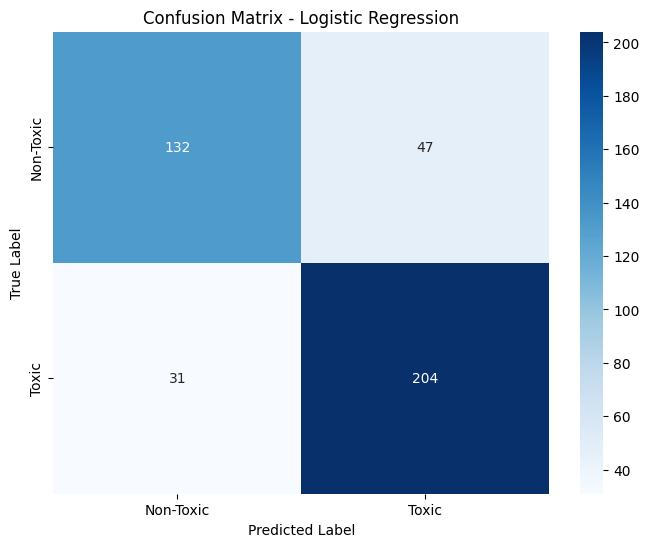


Detailed Classification Report - Logistic Regression
              precision    recall  f1-score   support

   Non-Toxic       0.81      0.74      0.77       179
       Toxic       0.81      0.87      0.84       235

    accuracy                           0.81       414
   macro avg       0.81      0.80      0.81       414
weighted avg       0.81      0.81      0.81       414


Additional Metrics:
Specificity (True Negative Rate): 0.7374
Sensitivity (True Positive Rate): 0.8681
False Positive Rate: 0.2626
False Negative Rate: 0.1319


In [60]:
best_results = results['Logistic Regression (Tuned)']
best_model_name = 'Logistic Regression'

y_pred = best_results['predictions']
y_pred_proba = best_results['probabilities']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nDetailed Classification Report - {best_model_name}")
print(classification_report(y_test, y_pred, target_names=['Non-Toxic', 'Toxic']))

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\nAdditional Metrics:")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"False Positive Rate: {fp/(fp+tn):.4f}")
print(f"False Negative Rate: {fn/(fn+tp):.4f}")

In [61]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    return text.strip()

def predict_from_input(model):
    print("Masukkan komentar untuk diprediksi (ketik 'exit' untuk keluar):\n")

    while True:
        comment = input("Komentar: ")

        if comment.lower() == 'exit':
            print("Keluar dari prediksi.")
            break

        processed = preprocess_text(comment)
        pred = model.predict([processed])[0]
        prob = model.predict_proba([processed])[0][1]

        print(f"\nHasil Prediksi")
        print(f"Teks asli: {comment}")
        print(f"Preprocessed: {processed}")
        print(f"Prediksi: {'Toxic' if pred else 'Non-Toxic'}")
        print(f"Keyakinan: {prob:.4f}\n")

predict_from_input(best_model)

Masukkan komentar untuk diprediksi (ketik 'exit' untuk keluar):

Komentar: halo nama saya rahmat

Hasil Prediksi
Teks asli: halo nama saya rahmat
Preprocessed: halo nama saya rahmat
Prediksi: Non-Toxic
Keyakinan: 0.4558

Komentar: exit
Keluar dari prediksi.


In [62]:
save_path = '/content/drive/MyDrive/projek/model/RedditToxiScan'

model_filename = os.path.join(save_path, 'toxic_detection_model.pkl')
vectorizer_filename = os.path.join(save_path, 'tfidf_vectorizer.pkl')

if hasattr(best_model, 'named_steps'):
    with open(model_filename, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"Model saved as: {model_filename}")
else:
    with open(model_filename, 'wb') as f:
        pickle.dump(best_model, f)
    with open(vectorizer_filename, 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    print(f"Model saved as: {model_filename}")
    print(f"Vectorizer saved as: {vectorizer_filename}")

Model saved as: /content/drive/MyDrive/projek/model/RedditToxiScan/toxic_detection_model.pkl
